In [20]:
import os
import torch
import yaml
from pathlib import Path
import random
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import plotly.graph_objects as go
from torch.utils.data import Dataset
import pyexr

from nerfstudio.configs import base_config as cfg
from nerfstudio.configs.method_configs import method_configs
from nerfstudio.data.dataparsers.nerfosr_dataparser import NeRFOSR, NeRFOSRDataParserConfig
from nerfstudio.pipelines.base_pipeline import VanillaDataManager
from nerfstudio.field_components.field_heads import FieldHeadNames
from nerfstudio.cameras.rays import RayBundle, RaySamples, Frustums
from nerfstudio.utils.colormaps import apply_depth_colormap
from nerfstudio.field_components.encodings import SHEncoding, NeRFEncoding
from nerfstudio.viewer.server import viewer_utils
import tinycudann as tcnn

from reni_neus.models.reni_neus_model import RENINeuSFactoModelConfig, RENINeuSFactoModel
from reni_neus.utils.utils import look_at_target, random_points_on_unit_sphere
from reni_neus.data.datamanagers.reni_neus_datamanager import RENINeuSDataManagerConfig, RENINeuSDataManager
from reni_neus.configs.ddf_config import DirectionalDistanceField
from reni_neus.configs.reni_neus_config import RENINeuS
from reni_neus.utils.utils import find_nerfstudio_project_root, rot_z

from reni.illumination_fields.environment_map_field import EnvironmentMapFieldConfig

project_root = find_nerfstudio_project_root(Path(os.getcwd()))
# set current working directory to nerfstudio project root
os.chdir(project_root)

# setup config
test_mode = 'test'
world_size = 1
local_rank = 0
device = 'cuda:0'

scene = 'site2'

reni_neus_config = RENINeuS
reni_neus_config.config.load_dir = Path(f'/workspace/reni_neus/models/{scene}/nerfstudio_models')
reni_neus_config.config.load_step = 100000
reni_neus_config.config.pipeline.datamanager.dataparser.scene = scene

if scene == 'site1':
    reni_neus_config.config.pipeline.datamanager.dataparser.session_holdout_indices=[0, 0, 0, 0, 0]
elif scene == 'site2':
    reni_neus_config.config.pipeline.datamanager.dataparser.session_holdout_indices=[1, 2, 2, 7, 9]
elif scene == 'site3':
    reni_neus_config.config.pipeline.datamanager.dataparser.session_holdout_indices=[0, 6, 6, 2, 11]

trainer = reni_neus_config.config.setup(local_rank=local_rank, world_size=world_size)
trainer.setup(test_mode=test_mode)
pipeline = trainer.pipeline
datamanager = pipeline.datamanager
model = pipeline.model
model = model.eval()

[10:30:53] Saving checkpoints to: outputs/reni-neus/reni-neus/{timestamp}/nerfstudio_models               ]8;id=976415;file:///workspace/nerfstudio/engine/trainer.py\trainer.py]8;;\:]8;id=82263;file:///workspace/nerfstudio/engine/trainer.py#134\134]8;;\

Setting up training dataset...

Caching all 301 images.

Output()

Setting up evaluation dataset...

Caching all 96 images.

Output()

Caching all 96 images.

Output()

╭─────────────────────────────────────────── Viewer ────────────────────────────────────────────╮
│        ╷                                                                                      │
│   HTTP │ ]8;id=321396;https://viewer.nerf.studio/versions/23-05-15-1/?websocket_url=ws://localhost:37011\https://viewer.nerf.studio/versions/23-05-15-1/?websocket_url=ws://localhost:37011]8;;\   │
│        ╵                                                                                      │
╰───────────────────────────────────────────────────────────────────────────────────────────────╯

[NOTE] Not running eval iterations since only viewer is enabled.
Use --vis {wandb, tensorboard, viewer+wandb, viewer+tensorboard} to run with eval.

Done loading Nerfstudio checkpoint from /workspace/reni_neus/models/site2/nerfstudio_models/step-000100000.ckpt

Disabled comet/tensorboard/wandb event writers

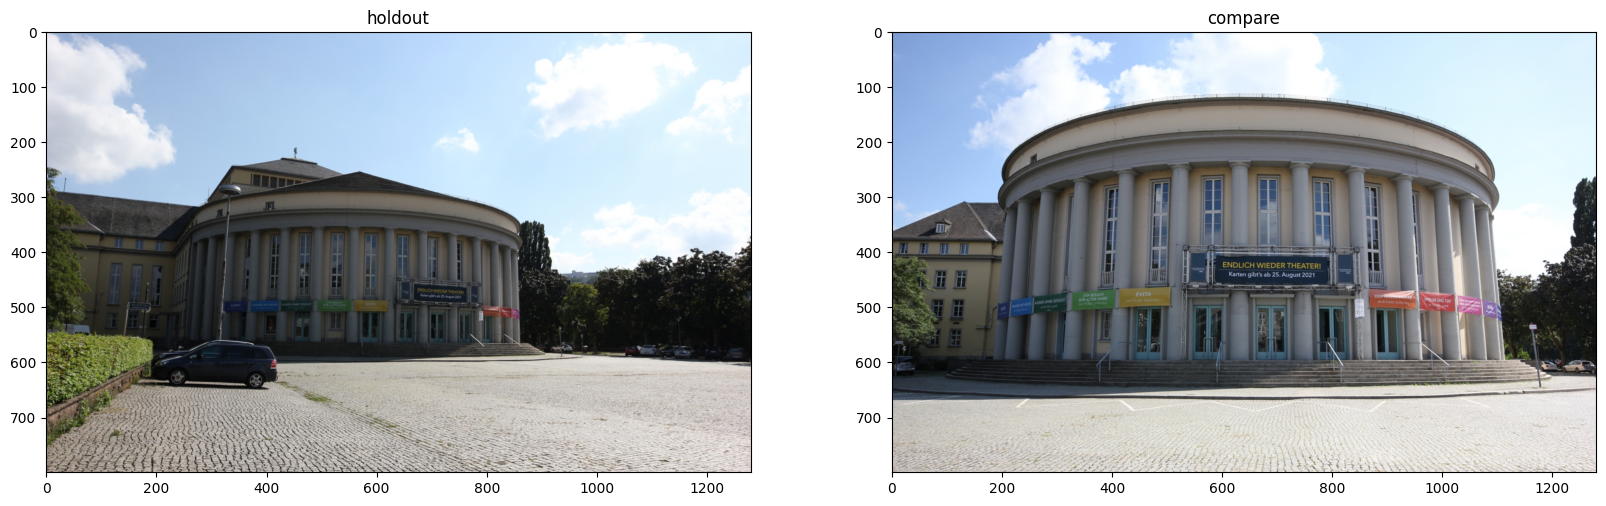

In [21]:
# Test Set Data
idx = 0
holdout_indices = datamanager.eval_session_holdout_dataloader.selected_indices
compare_indices = datamanager.eval_session_compare_dataloader.selected_indices
image_batch_holdout = datamanager.eval_dataset[holdout_indices[idx]]
image_batch_compare = datamanager.eval_dataset[compare_indices[idx]]
# plot both batch['image'] side by side
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(image_batch_holdout['image'].cpu().numpy())
axs[0].set_title('holdout')
axs[1].imshow(image_batch_compare['image'].cpu().numpy())
axs[1].set_title('compare')
plt.show()

In [8]:
blank_images = torch.zeros(5, 823, 1280, 3)

torch.Size([823, 1280, 3])

Processing batches: 100%|██████████| 10000/10000 [01:36<00:00, 103.79it/s]


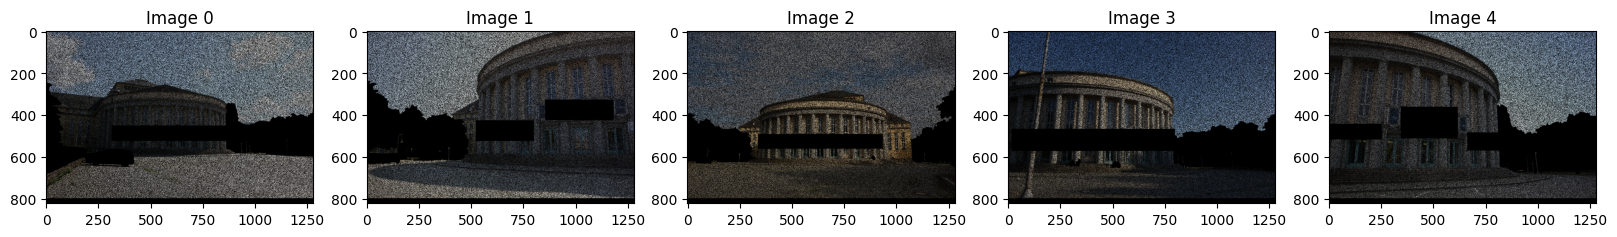

In [23]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

blank_images = torch.zeros(5, 823, 1280, 3)

# Wrap your range(1000) with tqdm for the progress bar
for i in tqdm(range(10000), desc='Processing batches'):
    _, batch = datamanager.get_nerfosr_lighting_eval_bundle('optimise')
    for idx, pixel in zip(batch['indices'], batch['image']):
        img_idx, x, y = idx  # Assuming the indices are [image_index, x_coordinate, y_coordinate]
        blank_images[img_idx, x, y] = pixel

# Plot all blank images
fig, axs = plt.subplots(1, 5, figsize=(20, 10))
for i in range(5):
    axs[i].imshow(blank_images[i].cpu().numpy())
    axs[i].set_title(f'Image {i}')
plt.show()
